In [1]:
import csv
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


import random

In [2]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import tensorflow as tf
from tqdm import tqdm

C:\Users\user\anaconda3\envs\downgrade\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\user\anaconda3\envs\downgrade\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


## 데이터 불러오기

In [3]:
#트레인

X= []
Y = []

f = open("train_data_4.csv" , 'r')
X = list(csv.reader(f, quoting = csv.QUOTE_NONNUMERIC))
X = np.array(X)
f.close()


f = open("train_label_0.csv" , 'r')
Y = list(csv.reader(f, quoting = csv.QUOTE_NONNUMERIC))
Y = np.array(Y)
Y = Y.T

f.close()

In [4]:
#테스트


x_test = []
label_test = []


f = open("test_data_4.csv" , 'r')
x_test = list(csv.reader(f, quoting = csv.QUOTE_NONNUMERIC))
x_test = np.array(x_test)
f.close()


f = open("test_label_0.csv" , 'r')
label_test = list(csv.reader(f, quoting = csv.QUOTE_NONNUMERIC))
label_test = np.array(label_test)
label_test = label_test.T
f.close()

In [5]:
#쉐이프 확인

print(np.shape(X))
print(np.shape(Y))

print(np.shape(x_test))
print(np.shape(label_test))

(1374, 50)
(1374, 1)
(700, 50)
(700, 1)


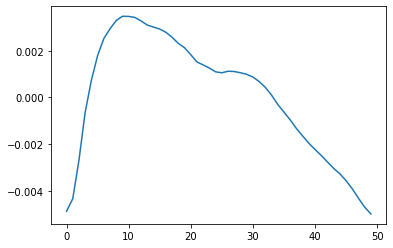

In [6]:
#그래프 확인
plt.plot(x_test[0])

In [7]:
#1d cnn에 넣기 위해 쉐이프 다시 지정

x_test = np.reshape(x_test,(700, 1, 50) )
x_test = x_test.tolist()
# pd.Series(x_test)

X = np.reshape(X,(1374, 1, 50) )
X = X.tolist()
# pd.Series(X)

# 모델 정의

### batch, epoch 설정

In [10]:
class Config():
    train_batch_size = 32
    test_batch_size = 1
    train_number_epochs = 500

### dataloader 

In [11]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset, label, train_batch_size):
        self.imageFolderDataset = imageFolderDataset
        self.label = label   
        self.train_batch_size = train_batch_size
        
    def __getitem__(self,index):
        
        
        img0_tuple = random.randint(0,len(self.label)-1) 
        
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.randint(0,len(self.label)-1) 
                
                if self.label[img0_tuple] == self.label[img1_tuple]:
                    break
        else:
            while True:
                
                #keep looping till a different class image is found
                img1_tuple = random.randint(0,len(self.label)-1) 
                if self.label[img0_tuple] != self.label[img1_tuple]:
                    break
        
        
#         print(self.label[img0_tuple])
#         print(self.label[img1_tuple])
#         print(int(self.label[img0_tuple] == self.label[img1_tuple]))
#         print("\n")
        
        
        
        img0 = self.imageFolderDataset[img0_tuple]
        img1 = self.imageFolderDataset[img1_tuple]
        
        img0 = torch.Tensor(img0)
        img1 = torch.Tensor(img1)
#         print(img0)
#         print("\n")
#         print(np.shape(img0))

#         print(np.shape(img0))



        return img0, img1 , torch.from_numpy(np.array([int(self.label[img0_tuple] == self.label[img1_tuple])],dtype=np.float32))
    
    def __len__(self):
        return (int(len(self.imageFolderDataset)-1)//(self.train_batch_size))

In [12]:
class SiameseNetworkDataset_test(Dataset):
    
    def __init__(self,imageFolderDataset, label, train_batch_size):
        self.imageFolderDataset = imageFolderDataset
        self.label = label   
        self.train_batch_size = train_batch_size
        
    def __getitem__(self,index):
        index = int(index)
        
        img0_tuple = index // int(len(self.label))
        img1_tuple = index % int(len(self.label))
        
        
        img0 = self.imageFolderDataset[img0_tuple]
        img1 = self.imageFolderDataset[img1_tuple]
        
        
#         print(self.label[img0_tuple])
#         print(self.label[img1_tuple])
#         print(int(self.label[img0_tuple] == self.label[img1_tuple]))
#         print("\n")
        
        
        
        img0 = torch.Tensor(img0)
        img1 = torch.Tensor(img1)
#         print(img0)
#         print("\n")
#         print(np.shape(img0))

#         print(np.shape(img0))



        return img0, img1 , torch.from_numpy(np.array([int(self.label[img0_tuple] == self.label[img1_tuple])],dtype=np.float32))
    
    def __len__(self):
        return int(len(self.imageFolderDataset)) * len(self.imageFolderDataset)

In [13]:
type(Config.train_batch_size)

int

## train_dataloader 

In [14]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=X, label = Y, train_batch_size  = 1)

In [15]:
train_dataloader = DataLoader(siamese_dataset, Config.train_batch_size, shuffle=False)

### 트레인 로더 잘 작동되는지 한단계씩 확인

In [16]:
dataiter = iter(train_dataloader)

In [17]:
example_batch = next(dataiter)

In [18]:
np.shape(example_batch[0])

torch.Size([32, 1, 50])

In [19]:
example_batch[0]

tensor([[[-0.0067, -0.0063, -0.0043,  ..., -0.0059, -0.0061, -0.0063]],

        [[-0.0069, -0.0059, -0.0034,  ..., -0.0059, -0.0062, -0.0065]],

        [[-0.0022, -0.0021, -0.0018,  ..., -0.0018, -0.0019, -0.0020]],

        ...,

        [[-0.0061, -0.0058, -0.0040,  ..., -0.0052, -0.0055, -0.0057]],

        [[-0.0017, -0.0016, -0.0013,  ..., -0.0013, -0.0014, -0.0016]],

        [[-0.0096, -0.0090, -0.0077,  ..., -0.0093, -0.0096, -0.0100]]])

In [21]:
example_batch[2]

tensor([[0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.]])

### SiameseNetwork

In [23]:
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(16),

            
            nn.Conv1d(16, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(32),


            
            nn.Conv1d(32, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(64),
            
            nn.Flatten(),
        )

 


        self.fc = nn.Sequential(
            nn.Linear(256 , 64),
            nn.ReLU(inplace=True),

            nn.Linear(64, 16),
            nn.ReLU(inplace=True),

            nn.Linear(16, 1),
            nn.Sigmoid())


#     def forward_once(self, x):
#         output = self.cnn1(x)
#         output = self.fc1(output)
#         return output

    def forward(self, input1, input2):
        output1 = self.cnn1(input1)
        output2 = self.cnn1(input2)
        
        sub = torch.subtract(output1,output2, alpha=1)
        
        
        
        output = self.fc(sub)

        
#         print(output)

        return output

# 모델 학습

In [25]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=False,
                        num_workers=0,
                        batch_size=Config.train_batch_size)

In [26]:
net = SiameseNetwork()
criterion = torch.nn.BCELoss(weight=None, size_average=None, reduce=None, reduction='mean')

optimizer = optim.Adam(net.parameters(),lr = 0.0001 )

In [1]:
#모델 구조 확인
import torchsummary
torchsummary.summary(net,[(1,50), (1, 50)])

NameError: name 'net' is not defined

In [28]:
counter = []
loss_history = [] 
acc = []
iteration_number= 0

In [29]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in tqdm(enumerate(train_dataloader, 0)):
        img0, img1 , label = data
        
        img0, img1 , label = img0, img1 , label
        optimizer.zero_grad()
        output = net.forward(img0,img1)
        
        
        
        
        loss = criterion(output, label)
        
        loss.backward()
        optimizer.step()
        
        
        
        if i %100 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss.item())
            
#             running_accuracy += (predicted == outputs).sum().item() 
#             accuracy = (100 * running_accuracy / total)
#             acc.append(accuracy)


25it [00:00, 121.51it/s]

Epoch number 0
 Current loss 0.6873942017555237



43it [00:00, 119.48it/s]
13it [00:00, 128.13it/s]

Epoch number 1
 Current loss 0.6205788254737854



43it [00:00, 123.37it/s]
13it [00:00, 124.06it/s]

Epoch number 2
 Current loss 0.6491876244544983



43it [00:00, 125.37it/s]
10it [00:00, 98.92it/s]

Epoch number 3
 Current loss 0.6226509213447571



43it [00:00, 114.13it/s]
13it [00:00, 119.00it/s]

Epoch number 4
 Current loss 0.540252149105072



43it [00:00, 121.48it/s]
13it [00:00, 121.77it/s]

Epoch number 5
 Current loss 0.6203524470329285



43it [00:00, 123.04it/s]
14it [00:00, 133.52it/s]

Epoch number 6
 Current loss 0.5945212244987488



43it [00:00, 126.76it/s]
13it [00:00, 120.23it/s]

Epoch number 7
 Current loss 0.5809636116027832



43it [00:00, 124.89it/s]
25it [00:00, 122.32it/s]

Epoch number 8
 Current loss 0.6334419250488281



43it [00:00, 122.57it/s]
24it [00:00, 116.48it/s]

Epoch number 9
 Current loss 0.6292959451675415



43it [00:00, 117.76it/s]
14it [00:00, 134.30it/s]

Epoch number 10
 Current loss 0.567253828048706



43it [00:00, 129.79it/s]
13it [00:00, 128.68it/s]

Epoch number 11
 Current loss 0.6025446653366089



43it [00:00, 124.16it/s]
26it [00:00, 125.35it/s]

Epoch number 12
 Current loss 0.5029004216194153



43it [00:00, 124.25it/s]
26it [00:00, 126.05it/s]

Epoch number 13
 Current loss 0.5041425228118896



43it [00:00, 124.38it/s]
13it [00:00, 123.72it/s]

Epoch number 14
 Current loss 0.5126028656959534



43it [00:00, 122.91it/s]
13it [00:00, 125.21it/s]

Epoch number 15
 Current loss 0.4565688371658325



43it [00:00, 113.69it/s]
9it [00:00, 86.59it/s]

Epoch number 16
 Current loss 0.4730013608932495



43it [00:00, 107.42it/s]
12it [00:00, 117.72it/s]

Epoch number 17
 Current loss 0.47123318910598755



43it [00:00, 113.16it/s]
11it [00:00, 100.87it/s]

Epoch number 18
 Current loss 0.4385242462158203



43it [00:00, 116.05it/s]
13it [00:00, 123.64it/s]

Epoch number 19
 Current loss 0.5290023684501648



43it [00:00, 106.02it/s]
12it [00:00, 116.13it/s]

Epoch number 20
 Current loss 0.42408111691474915



43it [00:00, 117.53it/s]
14it [00:00, 131.22it/s]

Epoch number 21
 Current loss 0.44851958751678467



43it [00:00, 131.54it/s]
26it [00:00, 128.16it/s]

Epoch number 22
 Current loss 0.4197174906730652



43it [00:00, 131.33it/s]
28it [00:00, 130.71it/s]

Epoch number 23
 Current loss 0.45707404613494873



43it [00:00, 129.76it/s]
24it [00:00, 116.22it/s]

Epoch number 24
 Current loss 0.3391323685646057



43it [00:00, 122.48it/s]
14it [00:00, 132.64it/s]

Epoch number 25
 Current loss 0.32067811489105225



43it [00:00, 123.48it/s]
12it [00:00, 116.79it/s]

Epoch number 26
 Current loss 0.2750701904296875



43it [00:00, 111.47it/s]
12it [00:00, 119.89it/s]

Epoch number 27
 Current loss 0.43411266803741455



43it [00:00, 110.38it/s]
13it [00:00, 124.38it/s]

Epoch number 28
 Current loss 0.38295209407806396



43it [00:00, 125.06it/s]
14it [00:00, 133.97it/s]

Epoch number 29
 Current loss 0.5190617442131042



43it [00:00, 126.08it/s]
13it [00:00, 120.20it/s]

Epoch number 30
 Current loss 0.37689220905303955



43it [00:00, 121.39it/s]
13it [00:00, 124.84it/s]

Epoch number 31
 Current loss 0.3693016767501831



43it [00:00, 115.85it/s]
12it [00:00, 112.22it/s]

Epoch number 32
 Current loss 0.4003826677799225



43it [00:00, 118.35it/s]
12it [00:00, 116.82it/s]

Epoch number 33
 Current loss 0.3509021997451782



43it [00:00, 121.65it/s]
13it [00:00, 124.59it/s]

Epoch number 34
 Current loss 0.3352768123149872



43it [00:00, 123.78it/s]
11it [00:00, 107.38it/s]

Epoch number 35
 Current loss 0.39803895354270935



43it [00:00, 113.34it/s]
26it [00:00, 125.95it/s]

Epoch number 36
 Current loss 0.36720582842826843



43it [00:00, 124.01it/s]
13it [00:00, 125.04it/s]

Epoch number 37
 Current loss 0.4231468439102173



43it [00:00, 119.37it/s]
12it [00:00, 116.56it/s]

Epoch number 38
 Current loss 0.26738977432250977



43it [00:00, 120.31it/s]
13it [00:00, 129.96it/s]

Epoch number 39
 Current loss 0.41808655858039856



43it [00:00, 123.01it/s]
13it [00:00, 126.34it/s]

Epoch number 40
 Current loss 0.28681042790412903



43it [00:00, 121.56it/s]
11it [00:00, 103.34it/s]

Epoch number 41
 Current loss 0.23768723011016846



43it [00:00, 118.98it/s]
14it [00:00, 133.14it/s]

Epoch number 42
 Current loss 0.4295562505722046



43it [00:00, 130.92it/s]
13it [00:00, 126.38it/s]

Epoch number 43
 Current loss 0.18315061926841736



43it [00:00, 124.10it/s]
13it [00:00, 123.61it/s]

Epoch number 44
 Current loss 0.3649510443210602



43it [00:00, 124.43it/s]
13it [00:00, 125.38it/s]

Epoch number 45
 Current loss 0.3490903973579407



43it [00:00, 126.25it/s]
26it [00:00, 129.49it/s]

Epoch number 46
 Current loss 0.28487205505371094



43it [00:00, 130.87it/s]
14it [00:00, 131.30it/s]

Epoch number 47
 Current loss 0.3230862617492676



43it [00:00, 117.99it/s]
13it [00:00, 119.84it/s]

Epoch number 48
 Current loss 0.28624725341796875



43it [00:00, 123.92it/s]
14it [00:00, 131.13it/s]

Epoch number 49
 Current loss 0.30587369203567505



43it [00:00, 120.08it/s]
14it [00:00, 130.57it/s]

Epoch number 50
 Current loss 0.16589660942554474



43it [00:00, 131.81it/s]
13it [00:00, 127.07it/s]

Epoch number 51
 Current loss 0.28437018394470215



43it [00:00, 131.56it/s]
14it [00:00, 130.79it/s]

Epoch number 52
 Current loss 0.21320132911205292



43it [00:00, 129.46it/s]
26it [00:00, 125.20it/s]

Epoch number 53
 Current loss 0.12703709304332733



43it [00:00, 125.56it/s]
12it [00:00, 112.04it/s]

Epoch number 54
 Current loss 0.2868833541870117



43it [00:00, 104.22it/s]
11it [00:00, 108.41it/s]

Epoch number 55
 Current loss 0.16180573403835297



43it [00:00, 113.27it/s]
13it [00:00, 128.28it/s]

Epoch number 56
 Current loss 0.2089202105998993



43it [00:00, 132.81it/s]
14it [00:00, 135.12it/s]

Epoch number 57
 Current loss 0.21453310549259186



43it [00:00, 130.44it/s]
26it [00:00, 122.41it/s]

Epoch number 58
 Current loss 0.1899082362651825



43it [00:00, 123.82it/s]
13it [00:00, 124.28it/s]

Epoch number 59
 Current loss 0.21136356890201569



43it [00:00, 127.59it/s]
28it [00:00, 135.38it/s]

Epoch number 60
 Current loss 0.13646836578845978



43it [00:00, 133.10it/s]
22it [00:00, 111.90it/s]

Epoch number 61
 Current loss 0.2843274176120758



43it [00:00, 117.08it/s]
26it [00:00, 126.91it/s]

Epoch number 62
 Current loss 0.16946235299110413



43it [00:00, 124.83it/s]
13it [00:00, 127.10it/s]

Epoch number 63
 Current loss 0.1463555246591568



43it [00:00, 127.66it/s]
13it [00:00, 121.56it/s]

Epoch number 64
 Current loss 0.2022690773010254



43it [00:00, 125.18it/s]
27it [00:00, 129.82it/s]

Epoch number 65
 Current loss 0.16846051812171936



43it [00:00, 127.66it/s]
14it [00:00, 133.14it/s]

Epoch number 66
 Current loss 0.1266535520553589



43it [00:00, 131.56it/s]
13it [00:00, 124.39it/s]

Epoch number 67
 Current loss 0.25287261605262756



43it [00:00, 124.95it/s]
14it [00:00, 132.36it/s]

Epoch number 68
 Current loss 0.16970345377922058



43it [00:00, 128.79it/s]
27it [00:00, 129.55it/s]

Epoch number 69
 Current loss 0.2628478705883026



43it [00:00, 129.30it/s]
13it [00:00, 125.45it/s]

Epoch number 70
 Current loss 0.22542251646518707



43it [00:00, 129.91it/s]
14it [00:00, 133.65it/s]

Epoch number 71
 Current loss 0.28352460265159607



43it [00:00, 130.19it/s]
26it [00:00, 127.44it/s]

Epoch number 72
 Current loss 0.2662690579891205



43it [00:00, 126.85it/s]
14it [00:00, 131.87it/s]

Epoch number 73
 Current loss 0.06119176000356674



43it [00:00, 126.46it/s]
12it [00:00, 118.69it/s]

Epoch number 74
 Current loss 0.36666640639305115



43it [00:00, 124.39it/s]
13it [00:00, 125.25it/s]

Epoch number 75
 Current loss 0.2801896929740906



43it [00:00, 126.15it/s]
14it [00:00, 129.48it/s]

Epoch number 76
 Current loss 0.23347072303295135



43it [00:00, 124.58it/s]
14it [00:00, 132.20it/s]

Epoch number 77
 Current loss 0.3537100851535797



43it [00:00, 117.46it/s]
12it [00:00, 119.63it/s]

Epoch number 78
 Current loss 0.13843272626399994



43it [00:00, 114.00it/s]
12it [00:00, 119.56it/s]

Epoch number 79
 Current loss 0.32958534359931946



43it [00:00, 120.10it/s]
14it [00:00, 131.87it/s]

Epoch number 80
 Current loss 0.12980720400810242



43it [00:00, 131.62it/s]
27it [00:00, 133.56it/s]

Epoch number 81
 Current loss 0.13366065919399261



43it [00:00, 130.65it/s]
13it [00:00, 126.79it/s]

Epoch number 82
 Current loss 0.14883092045783997



43it [00:00, 128.83it/s]
26it [00:00, 127.55it/s]

Epoch number 83
 Current loss 0.19910438358783722



43it [00:00, 126.47it/s]
14it [00:00, 132.40it/s]

Epoch number 84
 Current loss 0.2212025672197342



43it [00:00, 133.11it/s]
27it [00:00, 132.32it/s]

Epoch number 85
 Current loss 0.3271309733390808



43it [00:00, 125.54it/s]
14it [00:00, 131.13it/s]

Epoch number 86
 Current loss 0.19403646886348724



43it [00:00, 128.15it/s]
26it [00:00, 121.71it/s]

Epoch number 87
 Current loss 0.22018909454345703



43it [00:00, 124.82it/s]
14it [00:00, 133.81it/s]

Epoch number 88
 Current loss 0.1292051374912262



43it [00:00, 130.67it/s]
14it [00:00, 131.35it/s]

Epoch number 89
 Current loss 0.232122004032135



43it [00:00, 129.81it/s]
27it [00:00, 133.93it/s]

Epoch number 90
 Current loss 0.10451162606477737



43it [00:00, 131.78it/s]
27it [00:00, 130.33it/s]

Epoch number 91
 Current loss 0.12791308760643005



43it [00:00, 123.27it/s]
10it [00:00, 91.18it/s]

Epoch number 92
 Current loss 0.22473867237567902



43it [00:00, 114.81it/s]
27it [00:00, 132.96it/s]

Epoch number 93
 Current loss 0.23276473581790924



43it [00:00, 129.45it/s]
26it [00:00, 125.86it/s]

Epoch number 94
 Current loss 0.18929854035377502



43it [00:00, 127.43it/s]
25it [00:00, 122.48it/s]

Epoch number 95
 Current loss 0.053703684359788895



43it [00:00, 123.40it/s]
28it [00:00, 134.14it/s]

Epoch number 96
 Current loss 0.15968240797519684



43it [00:00, 127.60it/s]
13it [00:00, 129.56it/s]

Epoch number 97
 Current loss 0.12766945362091064



43it [00:00, 128.26it/s]
14it [00:00, 137.52it/s]

Epoch number 98
 Current loss 0.1294582486152649



43it [00:00, 132.86it/s]
13it [00:00, 124.74it/s]

Epoch number 99
 Current loss 0.1431034505367279



43it [00:00, 123.20it/s]
13it [00:00, 126.40it/s]

Epoch number 100
 Current loss 0.07259485125541687



43it [00:00, 128.27it/s]
13it [00:00, 128.31it/s]

Epoch number 101
 Current loss 0.2109539657831192



43it [00:00, 120.79it/s]
24it [00:00, 113.63it/s]

Epoch number 102
 Current loss 0.127412348985672



43it [00:00, 104.39it/s]
13it [00:00, 121.26it/s]

Epoch number 103
 Current loss 0.10969635099172592



43it [00:00, 119.83it/s]
13it [00:00, 125.75it/s]

Epoch number 104
 Current loss 0.1971609741449356



43it [00:00, 115.56it/s]
24it [00:00, 116.56it/s]

Epoch number 105
 Current loss 0.14186152815818787



43it [00:00, 117.95it/s]
12it [00:00, 119.35it/s]

Epoch number 106
 Current loss 0.10256554931402206



43it [00:00, 112.00it/s]
11it [00:00, 105.36it/s]

Epoch number 107
 Current loss 0.1523185670375824



43it [00:00, 109.18it/s]
26it [00:00, 125.70it/s]

Epoch number 108
 Current loss 0.12078298628330231



43it [00:00, 120.97it/s]
13it [00:00, 123.68it/s]

Epoch number 109
 Current loss 0.10953518748283386



43it [00:00, 125.88it/s]
12it [00:00, 111.84it/s]

Epoch number 110
 Current loss 0.1285802721977234



43it [00:00, 111.79it/s]
12it [00:00, 119.54it/s]

Epoch number 111
 Current loss 0.092421755194664



43it [00:00, 119.69it/s]
13it [00:00, 123.64it/s]

Epoch number 112
 Current loss 0.10852919518947601



43it [00:00, 119.55it/s]
13it [00:00, 121.03it/s]

Epoch number 113
 Current loss 0.05620763823390007



43it [00:00, 120.99it/s]
26it [00:00, 126.83it/s]

Epoch number 114
 Current loss 0.07851378619670868



43it [00:00, 121.48it/s]
12it [00:00, 116.95it/s]

Epoch number 115
 Current loss 0.30947527289390564



43it [00:00, 124.22it/s]
13it [00:00, 127.61it/s]

Epoch number 116
 Current loss 0.29257866740226746



43it [00:00, 123.81it/s]
13it [00:00, 122.73it/s]

Epoch number 117
 Current loss 0.1359969824552536



43it [00:00, 121.12it/s]
13it [00:00, 122.44it/s]

Epoch number 118
 Current loss 0.14607536792755127



43it [00:00, 122.60it/s]
13it [00:00, 119.84it/s]

Epoch number 119
 Current loss 0.20052188634872437



43it [00:00, 123.26it/s]
12it [00:00, 114.13it/s]

Epoch number 120
 Current loss 0.21556541323661804



43it [00:00, 117.59it/s]
26it [00:00, 129.08it/s]

Epoch number 121
 Current loss 0.19462378323078156



43it [00:00, 112.45it/s]
26it [00:00, 125.57it/s]

Epoch number 122
 Current loss 0.11995013803243637



43it [00:00, 123.15it/s]
13it [00:00, 120.61it/s]

Epoch number 123
 Current loss 0.29458677768707275



43it [00:00, 121.94it/s]
13it [00:00, 121.45it/s]

Epoch number 124
 Current loss 0.0975516140460968



43it [00:00, 122.64it/s]
25it [00:00, 118.37it/s]

Epoch number 125
 Current loss 0.09742703288793564



43it [00:00, 116.87it/s]
12it [00:00, 117.26it/s]

Epoch number 126
 Current loss 0.14843863248825073



43it [00:00, 119.62it/s]
13it [00:00, 127.99it/s]

Epoch number 127
 Current loss 0.11238105595111847



43it [00:00, 126.56it/s]
13it [00:00, 124.49it/s]

Epoch number 128
 Current loss 0.12339265644550323



43it [00:00, 125.52it/s]
12it [00:00, 117.80it/s]

Epoch number 129
 Current loss 0.09798842668533325



43it [00:00, 120.72it/s]
26it [00:00, 122.92it/s]

Epoch number 130
 Current loss 0.2827434539794922



43it [00:00, 123.59it/s]
13it [00:00, 126.89it/s]

Epoch number 131
 Current loss 0.19685925543308258



43it [00:00, 118.89it/s]
26it [00:00, 125.97it/s]

Epoch number 132
 Current loss 0.3674885928630829



43it [00:00, 126.23it/s]
13it [00:00, 126.55it/s]

Epoch number 133
 Current loss 0.20713546872138977



43it [00:00, 122.99it/s]
13it [00:00, 120.33it/s]

Epoch number 134
 Current loss 0.3295093774795532



43it [00:00, 116.80it/s]
11it [00:00, 104.12it/s]

Epoch number 135
 Current loss 0.08651696145534515



43it [00:00, 107.91it/s]
12it [00:00, 115.52it/s]

Epoch number 136
 Current loss 0.1957612931728363



43it [00:00, 111.34it/s]
12it [00:00, 116.37it/s]

Epoch number 137
 Current loss 0.06645049154758453



43it [00:00, 117.94it/s]
13it [00:00, 122.65it/s]

Epoch number 138
 Current loss 0.1984717696905136



43it [00:00, 123.21it/s]
13it [00:00, 124.73it/s]

Epoch number 139
 Current loss 0.22538018226623535



43it [00:00, 124.25it/s]
13it [00:00, 122.36it/s]

Epoch number 140
 Current loss 0.21210578083992004



43it [00:00, 122.26it/s]
13it [00:00, 129.19it/s]

Epoch number 141
 Current loss 0.04852314293384552



43it [00:00, 124.25it/s]
12it [00:00, 116.60it/s]

Epoch number 142
 Current loss 0.09869623184204102



43it [00:00, 118.07it/s]
24it [00:00, 119.44it/s]

Epoch number 143
 Current loss 0.09000784903764725



43it [00:00, 120.91it/s]
13it [00:00, 123.06it/s]

Epoch number 144
 Current loss 0.22660839557647705



43it [00:00, 123.36it/s]
13it [00:00, 124.79it/s]

Epoch number 145
 Current loss 0.11322390288114548



43it [00:00, 106.63it/s]
13it [00:00, 121.75it/s]

Epoch number 146
 Current loss 0.17453476786613464



43it [00:00, 123.26it/s]
13it [00:00, 121.14it/s]

Epoch number 147
 Current loss 0.11206010729074478



43it [00:00, 123.91it/s]
13it [00:00, 121.72it/s]

Epoch number 148
 Current loss 0.06165812909603119



43it [00:00, 124.03it/s]
12it [00:00, 118.26it/s]

Epoch number 149
 Current loss 0.04806686192750931



43it [00:00, 121.12it/s]
13it [00:00, 126.84it/s]

Epoch number 150
 Current loss 0.11514458805322647



43it [00:00, 122.85it/s]
13it [00:00, 123.83it/s]

Epoch number 151
 Current loss 0.17141073942184448



43it [00:00, 126.29it/s]
26it [00:00, 125.76it/s]

Epoch number 152
 Current loss 0.06023728847503662



43it [00:00, 124.09it/s]
13it [00:00, 124.52it/s]

Epoch number 153
 Current loss 0.12543736398220062



43it [00:00, 122.55it/s]
14it [00:00, 131.77it/s]

Epoch number 154
 Current loss 0.09941066056489944



43it [00:00, 125.12it/s]
26it [00:00, 125.95it/s]

Epoch number 155
 Current loss 0.1131075918674469



43it [00:00, 123.77it/s]
25it [00:00, 125.09it/s]

Epoch number 156
 Current loss 0.07314937561750412



43it [00:00, 123.53it/s]
14it [00:00, 133.01it/s]

Epoch number 157
 Current loss 0.06884986162185669



43it [00:00, 122.90it/s]
13it [00:00, 122.22it/s]

Epoch number 158
 Current loss 0.11157482117414474



43it [00:00, 120.04it/s]
12it [00:00, 118.87it/s]

Epoch number 159
 Current loss 0.27650338411331177



43it [00:00, 117.95it/s]
13it [00:00, 121.66it/s]

Epoch number 160
 Current loss 0.09203726798295975



43it [00:00, 120.60it/s]
13it [00:00, 121.90it/s]

Epoch number 161
 Current loss 0.04703902080655098



43it [00:00, 122.11it/s]
13it [00:00, 123.27it/s]

Epoch number 162
 Current loss 0.06285890936851501



43it [00:00, 125.23it/s]
25it [00:00, 123.98it/s]

Epoch number 163
 Current loss 0.09140282869338989



43it [00:00, 120.74it/s]
13it [00:00, 124.51it/s]

Epoch number 164
 Current loss 0.07525434345006943



43it [00:00, 122.56it/s]
25it [00:00, 123.50it/s]

Epoch number 165
 Current loss 0.1247035413980484



43it [00:00, 121.89it/s]
13it [00:00, 123.00it/s]

Epoch number 166
 Current loss 0.06526452302932739



43it [00:00, 119.40it/s]
13it [00:00, 129.94it/s]

Epoch number 167
 Current loss 0.1042981967329979



43it [00:00, 126.60it/s]
26it [00:00, 127.17it/s]

Epoch number 168
 Current loss 0.0712900385260582



43it [00:00, 124.00it/s]
13it [00:00, 124.33it/s]

Epoch number 169
 Current loss 0.09444447606801987



43it [00:00, 121.09it/s]
13it [00:00, 129.90it/s]

Epoch number 170
 Current loss 0.08910375833511353



43it [00:00, 124.80it/s]
13it [00:00, 124.21it/s]

Epoch number 171
 Current loss 0.24310941994190216



43it [00:00, 123.42it/s]
12it [00:00, 111.93it/s]

Epoch number 172
 Current loss 0.10192867368459702



43it [00:00, 100.98it/s]
12it [00:00, 113.22it/s]

Epoch number 173
 Current loss 0.06915967166423798



43it [00:00, 122.21it/s]
26it [00:00, 129.09it/s]

Epoch number 174
 Current loss 0.0384259894490242



43it [00:00, 123.83it/s]
13it [00:00, 123.29it/s]

Epoch number 175
 Current loss 0.14121279120445251



43it [00:00, 114.05it/s]
13it [00:00, 124.25it/s]

Epoch number 176
 Current loss 0.2038528472185135



43it [00:00, 124.22it/s]
13it [00:00, 121.74it/s]

Epoch number 177
 Current loss 0.1520489752292633



43it [00:00, 118.83it/s]
13it [00:00, 121.83it/s]

Epoch number 178
 Current loss 0.04753623530268669



43it [00:00, 119.99it/s]
13it [00:00, 123.34it/s]

Epoch number 179
 Current loss 0.07292760908603668



43it [00:00, 122.77it/s]
25it [00:00, 122.10it/s]

Epoch number 180
 Current loss 0.04066552221775055



43it [00:00, 121.65it/s]
13it [00:00, 122.73it/s]

Epoch number 181
 Current loss 0.19260673224925995



43it [00:00, 122.76it/s]
12it [00:00, 119.52it/s]

Epoch number 182
 Current loss 0.05941830575466156



43it [00:00, 118.70it/s]
13it [00:00, 124.27it/s]

Epoch number 183
 Current loss 0.014779265969991684



43it [00:00, 119.85it/s]
13it [00:00, 119.65it/s]

Epoch number 184
 Current loss 0.11147522926330566



43it [00:00, 121.64it/s]
25it [00:00, 122.82it/s]

Epoch number 185
 Current loss 0.14738288521766663



43it [00:00, 121.48it/s]
13it [00:00, 124.08it/s]

Epoch number 186
 Current loss 0.11024952679872513



43it [00:00, 123.52it/s]
13it [00:00, 119.72it/s]

Epoch number 187
 Current loss 0.159884512424469



43it [00:00, 122.54it/s]
27it [00:00, 129.70it/s]

Epoch number 188
 Current loss 0.1573033183813095



43it [00:00, 125.17it/s]
25it [00:00, 122.46it/s]

Epoch number 189
 Current loss 0.06524758785963058



43it [00:00, 117.42it/s]
12it [00:00, 115.29it/s]

Epoch number 190
 Current loss 0.14065849781036377



43it [00:00, 119.41it/s]
14it [00:00, 133.76it/s]

Epoch number 191
 Current loss 0.0927344337105751



43it [00:00, 122.59it/s]
12it [00:00, 115.50it/s]

Epoch number 192
 Current loss 0.08415503799915314



43it [00:00, 112.53it/s]
24it [00:00, 117.02it/s]

Epoch number 193
 Current loss 0.12962450087070465



43it [00:00, 117.01it/s]
14it [00:00, 134.02it/s]

Epoch number 194
 Current loss 0.03176741302013397



43it [00:00, 126.38it/s]
13it [00:00, 122.65it/s]

Epoch number 195
 Current loss 0.1257338970899582



43it [00:00, 117.38it/s]
26it [00:00, 126.50it/s]

Epoch number 196
 Current loss 0.12309317290782928



43it [00:00, 123.20it/s]
13it [00:00, 121.91it/s]

Epoch number 197
 Current loss 0.14530637860298157



43it [00:00, 121.40it/s]
13it [00:00, 127.16it/s]

Epoch number 198
 Current loss 0.16638310253620148



43it [00:00, 123.88it/s]
11it [00:00, 107.01it/s]

Epoch number 199
 Current loss 0.07849191129207611



43it [00:00, 116.35it/s]
13it [00:00, 124.37it/s]

Epoch number 200
 Current loss 0.10802282392978668



43it [00:00, 124.47it/s]
25it [00:00, 120.23it/s]

Epoch number 201
 Current loss 0.06891946494579315



43it [00:00, 118.92it/s]
12it [00:00, 115.06it/s]

Epoch number 202
 Current loss 0.24846459925174713



43it [00:00, 118.53it/s]
13it [00:00, 123.72it/s]

Epoch number 203
 Current loss 0.07730758935213089



43it [00:00, 120.34it/s]
12it [00:00, 117.78it/s]

Epoch number 204
 Current loss 0.19656625390052795



43it [00:00, 120.45it/s]
27it [00:00, 127.71it/s]

Epoch number 205
 Current loss 0.078175388276577



43it [00:00, 123.99it/s]
12it [00:00, 114.95it/s]

Epoch number 206
 Current loss 0.033830106258392334



43it [00:00, 118.71it/s]
13it [00:00, 123.55it/s]

Epoch number 207
 Current loss 0.042230576276779175



43it [00:00, 122.96it/s]
14it [00:00, 130.02it/s]

Epoch number 208
 Current loss 0.06849953532218933



43it [00:00, 126.59it/s]
12it [00:00, 112.87it/s]

Epoch number 209
 Current loss 0.17419065535068512



43it [00:00, 120.07it/s]
13it [00:00, 126.04it/s]

Epoch number 210
 Current loss 0.03808547183871269



43it [00:00, 122.04it/s]
13it [00:00, 126.92it/s]

Epoch number 211
 Current loss 0.18385598063468933



43it [00:00, 111.35it/s]
25it [00:00, 122.94it/s]

Epoch number 212
 Current loss 0.06607536226511002



43it [00:00, 119.02it/s]
13it [00:00, 124.75it/s]

Epoch number 213
 Current loss 0.22616833448410034



43it [00:00, 121.34it/s]
24it [00:00, 115.79it/s]

Epoch number 214
 Current loss 0.13933223485946655



43it [00:00, 114.60it/s]
12it [00:00, 114.07it/s]

Epoch number 215
 Current loss 0.12882103025913239



43it [00:00, 118.43it/s]
13it [00:00, 124.98it/s]

Epoch number 216
 Current loss 0.05505945533514023



43it [00:00, 122.23it/s]
13it [00:00, 123.19it/s]

Epoch number 217
 Current loss 0.07771312445402145



43it [00:00, 120.40it/s]
12it [00:00, 119.92it/s]

Epoch number 218
 Current loss 0.120493583381176



43it [00:00, 119.80it/s]
26it [00:00, 126.98it/s]

Epoch number 219
 Current loss 0.1594853699207306



43it [00:00, 122.22it/s]
13it [00:00, 122.49it/s]

Epoch number 220
 Current loss 0.046245891600847244



43it [00:00, 123.27it/s]
12it [00:00, 119.29it/s]

Epoch number 221
 Current loss 0.13034003973007202



43it [00:00, 122.05it/s]
25it [00:00, 121.07it/s]

Epoch number 222
 Current loss 0.041947755962610245



43it [00:00, 122.47it/s]
13it [00:00, 123.34it/s]

Epoch number 223
 Current loss 0.11633551120758057



43it [00:00, 125.77it/s]
12it [00:00, 117.11it/s]

Epoch number 224
 Current loss 0.10023949295282364



43it [00:00, 122.94it/s]
26it [00:00, 125.56it/s]

Epoch number 225
 Current loss 0.29834145307540894



43it [00:00, 124.27it/s]
26it [00:00, 122.42it/s]

Epoch number 226
 Current loss 0.11775264143943787



43it [00:00, 121.97it/s]
13it [00:00, 123.01it/s]

Epoch number 227
 Current loss 0.031197553500533104



43it [00:00, 121.41it/s]
13it [00:00, 123.29it/s]

Epoch number 228
 Current loss 0.062476277351379395



43it [00:00, 121.17it/s]
13it [00:00, 122.62it/s]

Epoch number 229
 Current loss 0.052873171865940094



43it [00:00, 114.83it/s]
11it [00:00, 107.73it/s]

Epoch number 230
 Current loss 0.05498775467276573



43it [00:00, 111.79it/s]
12it [00:00, 118.01it/s]

Epoch number 231
 Current loss 0.09095411002635956



43it [00:00, 111.72it/s]
12it [00:00, 115.89it/s]

Epoch number 232
 Current loss 0.08284169435501099



43it [00:00, 119.76it/s]
13it [00:00, 123.40it/s]

Epoch number 233
 Current loss 0.11379610747098923



43it [00:00, 120.21it/s]
12it [00:00, 118.65it/s]

Epoch number 234
 Current loss 0.02941148355603218



43it [00:00, 107.49it/s]
11it [00:00, 106.41it/s]

Epoch number 235
 Current loss 0.10366004705429077



43it [00:00, 106.82it/s]
12it [00:00, 118.80it/s]

Epoch number 236
 Current loss 0.10634589195251465



43it [00:00, 112.18it/s]
7it [00:00, 67.69it/s]

Epoch number 237
 Current loss 0.13905806839466095



43it [00:00, 100.74it/s]
11it [00:00, 107.96it/s]

Epoch number 238
 Current loss 0.24315078556537628



43it [00:00, 111.85it/s]
12it [00:00, 111.82it/s]

Epoch number 239
 Current loss 0.02710428461432457



43it [00:00, 113.57it/s]
12it [00:00, 119.63it/s]

Epoch number 240
 Current loss 0.0650179460644722



43it [00:00, 113.25it/s]
12it [00:00, 118.40it/s]

Epoch number 241
 Current loss 0.13484546542167664



43it [00:00, 113.01it/s]
12it [00:00, 115.09it/s]

Epoch number 242
 Current loss 0.038753218948841095



43it [00:00, 120.82it/s]
11it [00:00, 109.87it/s]

Epoch number 243
 Current loss 0.19552356004714966



43it [00:00, 110.22it/s]
12it [00:00, 114.78it/s]

Epoch number 244
 Current loss 0.15037406980991364



43it [00:00, 113.65it/s]
12it [00:00, 115.68it/s]

Epoch number 245
 Current loss 0.021659482270479202



43it [00:00, 114.30it/s]
21it [00:00, 102.88it/s]

Epoch number 246
 Current loss 0.04129980877041817



43it [00:00, 104.36it/s]
24it [00:00, 112.17it/s]

Epoch number 247
 Current loss 0.096702940762043



43it [00:00, 112.82it/s]
12it [00:00, 111.19it/s]

Epoch number 248
 Current loss 0.019720235839486122



43it [00:00, 111.98it/s]
13it [00:00, 119.53it/s]

Epoch number 249
 Current loss 0.2683715224266052



43it [00:00, 115.30it/s]
13it [00:00, 119.49it/s]

Epoch number 250
 Current loss 0.16348780691623688



43it [00:00, 119.13it/s]
13it [00:00, 122.75it/s]

Epoch number 251
 Current loss 0.12886638939380646



43it [00:00, 110.97it/s]
12it [00:00, 110.73it/s]

Epoch number 252
 Current loss 0.16163264214992523



43it [00:00, 113.39it/s]
12it [00:00, 112.51it/s]

Epoch number 253
 Current loss 0.03822106868028641



43it [00:00, 117.76it/s]
26it [00:00, 120.06it/s]

Epoch number 254
 Current loss 0.1218704879283905



43it [00:00, 114.00it/s]
23it [00:00, 114.59it/s]

Epoch number 255
 Current loss 0.03213087469339371



43it [00:00, 113.40it/s]
12it [00:00, 112.14it/s]

Epoch number 256
 Current loss 0.04614415019750595



43it [00:00, 112.74it/s]
13it [00:00, 122.00it/s]

Epoch number 257
 Current loss 0.08141906559467316



43it [00:00, 113.79it/s]
22it [00:00, 109.85it/s]

Epoch number 258
 Current loss 0.07157120108604431



43it [00:00, 111.17it/s]
12it [00:00, 117.10it/s]

Epoch number 259
 Current loss 0.041276346892118454



43it [00:00, 111.22it/s]
10it [00:00, 95.39it/s]

Epoch number 260
 Current loss 0.03843804821372032



43it [00:00, 102.75it/s]
10it [00:00, 98.06it/s]

Epoch number 261
 Current loss 0.05171305313706398



43it [00:00, 89.94it/s]
21it [00:00, 101.39it/s]

Epoch number 262
 Current loss 0.0869402140378952



43it [00:00, 101.05it/s]
11it [00:00, 101.17it/s]

Epoch number 263
 Current loss 0.11203625053167343



43it [00:00, 112.15it/s]
11it [00:00, 109.22it/s]

Epoch number 264
 Current loss 0.22248893976211548



43it [00:00, 112.27it/s]
24it [00:00, 118.22it/s]

Epoch number 265
 Current loss 0.0432269424200058



43it [00:00, 111.46it/s]
12it [00:00, 113.85it/s]

Epoch number 266
 Current loss 0.12350570410490036



43it [00:00, 114.65it/s]
11it [00:00, 106.39it/s]

Epoch number 267
 Current loss 0.0784793496131897



43it [00:00, 115.49it/s]
11it [00:00, 104.21it/s]

Epoch number 268
 Current loss 0.04500000923871994



43it [00:00, 104.74it/s]
12it [00:00, 116.08it/s]

Epoch number 269
 Current loss 0.033306531608104706



43it [00:00, 114.87it/s]
12it [00:00, 115.26it/s]

Epoch number 270
 Current loss 0.060712866485118866



43it [00:00, 109.46it/s]
10it [00:00, 97.85it/s]

Epoch number 271
 Current loss 0.06423857063055038



43it [00:00, 95.85it/s]
22it [00:00, 106.13it/s]

Epoch number 272
 Current loss 0.043723881244659424



43it [00:00, 106.28it/s]
11it [00:00, 105.06it/s]

Epoch number 273
 Current loss 0.24248090386390686



43it [00:00, 109.57it/s]
12it [00:00, 114.14it/s]

Epoch number 274
 Current loss 0.07856455445289612



43it [00:00, 111.28it/s]
11it [00:00, 104.91it/s]

Epoch number 275
 Current loss 0.029928084462881088



43it [00:00, 114.23it/s]
13it [00:00, 123.24it/s]

Epoch number 276
 Current loss 0.04705313965678215



43it [00:00, 112.66it/s]
11it [00:00, 103.58it/s]

Epoch number 277
 Current loss 0.018580399453639984



43it [00:00, 108.82it/s]
26it [00:00, 126.39it/s]

Epoch number 278
 Current loss 0.04814104363322258



43it [00:00, 120.63it/s]
11it [00:00, 101.26it/s]

Epoch number 279
 Current loss 0.06478675454854965



43it [00:00, 105.50it/s]
13it [00:00, 120.63it/s]

Epoch number 280
 Current loss 0.19688142836093903



43it [00:00, 112.45it/s]
12it [00:00, 109.71it/s]

Epoch number 281
 Current loss 0.19807058572769165



43it [00:00, 113.17it/s]
13it [00:00, 124.12it/s]

Epoch number 282
 Current loss 0.15936562418937683



43it [00:00, 115.55it/s]
11it [00:00, 105.20it/s]

Epoch number 283
 Current loss 0.08651699870824814



43it [00:00, 104.57it/s]
10it [00:00, 95.65it/s]

Epoch number 284
 Current loss 0.04755377769470215



43it [00:00, 105.24it/s]
23it [00:00, 112.10it/s]

Epoch number 285
 Current loss 0.23307588696479797



43it [00:00, 113.96it/s]
7it [00:00, 67.85it/s]

Epoch number 286
 Current loss 0.03974214568734169



43it [00:00, 95.95it/s]
12it [00:00, 118.03it/s]

Epoch number 287
 Current loss 0.04221393167972565



43it [00:00, 111.87it/s]
10it [00:00, 96.47it/s]

Epoch number 288
 Current loss 0.09528212994337082



43it [00:00, 102.01it/s]
11it [00:00, 102.17it/s]

Epoch number 289
 Current loss 0.017703667283058167



43it [00:00, 108.72it/s]
12it [00:00, 118.47it/s]

Epoch number 290
 Current loss 0.00862579233944416



43it [00:00, 116.75it/s]
12it [00:00, 111.28it/s]

Epoch number 291
 Current loss 0.04218585044145584



43it [00:00, 110.96it/s]
12it [00:00, 119.52it/s]

Epoch number 292
 Current loss 0.024209480732679367



43it [00:00, 115.37it/s]
12it [00:00, 112.15it/s]

Epoch number 293
 Current loss 0.044977955520153046



43it [00:00, 112.20it/s]
13it [00:00, 122.75it/s]

Epoch number 294
 Current loss 0.033934008330106735



43it [00:00, 120.19it/s]
13it [00:00, 119.30it/s]

Epoch number 295
 Current loss 0.13244850933551788



43it [00:00, 111.47it/s]
11it [00:00, 102.55it/s]

Epoch number 296
 Current loss 0.017876246944069862



43it [00:00, 109.00it/s]
12it [00:00, 113.68it/s]

Epoch number 297
 Current loss 0.0179598368704319



43it [00:00, 110.83it/s]
12it [00:00, 115.90it/s]

Epoch number 298
 Current loss 0.027101540938019753



43it [00:00, 114.17it/s]
12it [00:00, 110.11it/s]

Epoch number 299
 Current loss 0.05929800122976303



43it [00:00, 108.37it/s]
12it [00:00, 114.63it/s]

Epoch number 300
 Current loss 0.06028322875499725



43it [00:00, 115.50it/s]
13it [00:00, 121.12it/s]

Epoch number 301
 Current loss 0.08284903317689896



43it [00:00, 117.91it/s]
13it [00:00, 128.50it/s]

Epoch number 302
 Current loss 0.049013905227184296



43it [00:00, 118.46it/s]
12it [00:00, 119.30it/s]

Epoch number 303
 Current loss 0.24031229317188263



43it [00:00, 114.45it/s]
24it [00:00, 117.10it/s]

Epoch number 304
 Current loss 0.08009937405586243



43it [00:00, 116.76it/s]
13it [00:00, 119.30it/s]

Epoch number 305
 Current loss 0.0840136930346489



43it [00:00, 111.20it/s]
12it [00:00, 109.75it/s]

Epoch number 306
 Current loss 0.2506415843963623



43it [00:00, 113.46it/s]
19it [00:00, 92.60it/s]

Epoch number 307
 Current loss 0.016210071742534637



43it [00:00, 100.97it/s]
13it [00:00, 123.32it/s]

Epoch number 308
 Current loss 0.16012831032276154



43it [00:00, 119.90it/s]
13it [00:00, 124.35it/s]

Epoch number 309
 Current loss 0.058917272835969925



43it [00:00, 121.79it/s]
10it [00:00, 94.81it/s]

Epoch number 310
 Current loss 0.06119171902537346



43it [00:00, 104.50it/s]
12it [00:00, 113.79it/s]

Epoch number 311
 Current loss 0.18744216859340668



43it [00:00, 113.21it/s]
24it [00:00, 114.54it/s]

Epoch number 312
 Current loss 0.0379185825586319



43it [00:00, 114.57it/s]
11it [00:00, 108.22it/s]

Epoch number 313
 Current loss 0.08720468729734421



43it [00:00, 109.09it/s]
13it [00:00, 121.08it/s]

Epoch number 314
 Current loss 0.1783258020877838



43it [00:00, 115.74it/s]
12it [00:00, 115.25it/s]

Epoch number 315
 Current loss 0.02184601128101349



43it [00:00, 113.26it/s]
12it [00:00, 118.01it/s]

Epoch number 316
 Current loss 0.0648740604519844



43it [00:00, 118.26it/s]
12it [00:00, 111.82it/s]

Epoch number 317
 Current loss 0.17080220580101013



43it [00:00, 109.44it/s]
11it [00:00, 109.68it/s]

Epoch number 318
 Current loss 0.03296221047639847



43it [00:00, 113.52it/s]
12it [00:00, 114.55it/s]

Epoch number 319
 Current loss 0.01847708597779274



43it [00:00, 117.11it/s]
12it [00:00, 116.06it/s]

Epoch number 320
 Current loss 0.14801912009716034



43it [00:00, 111.01it/s]
13it [00:00, 120.11it/s]

Epoch number 321
 Current loss 0.05359940230846405



43it [00:00, 119.04it/s]
12it [00:00, 119.91it/s]

Epoch number 322
 Current loss 0.09897986054420471



43it [00:00, 111.59it/s]
12it [00:00, 109.34it/s]

Epoch number 323
 Current loss 0.07807555049657822



43it [00:00, 114.45it/s]
13it [00:00, 123.71it/s]

Epoch number 324
 Current loss 0.10769499838352203



43it [00:00, 120.60it/s]
24it [00:00, 114.85it/s]

Epoch number 325
 Current loss 0.1210232526063919



43it [00:00, 113.32it/s]
11it [00:00, 102.73it/s]

Epoch number 326
 Current loss 0.09248052537441254



43it [00:00, 112.38it/s]
11it [00:00, 106.05it/s]

Epoch number 327
 Current loss 0.022309893742203712



43it [00:00, 113.39it/s]
12it [00:00, 118.68it/s]

Epoch number 328
 Current loss 0.03409348428249359



43it [00:00, 118.32it/s]
24it [00:00, 115.92it/s]

Epoch number 329
 Current loss 0.01631702482700348



43it [00:00, 118.21it/s]
24it [00:00, 114.69it/s]

Epoch number 330
 Current loss 0.07260818034410477



43it [00:00, 113.47it/s]
11it [00:00, 103.18it/s]

Epoch number 331
 Current loss 0.01891052909195423



43it [00:00, 112.60it/s]
13it [00:00, 120.92it/s]

Epoch number 332
 Current loss 0.11843113601207733



43it [00:00, 118.90it/s]
13it [00:00, 128.38it/s]

Epoch number 333
 Current loss 0.04193326085805893



43it [00:00, 107.22it/s]
13it [00:00, 122.50it/s]

Epoch number 334
 Current loss 0.21574458479881287



43it [00:00, 111.24it/s]
22it [00:00, 107.10it/s]

Epoch number 335
 Current loss 0.05971096083521843



43it [00:00, 112.31it/s]
24it [00:00, 117.48it/s]

Epoch number 336
 Current loss 0.011877735145390034



43it [00:00, 112.68it/s]
10it [00:00, 97.26it/s]

Epoch number 337
 Current loss 0.1612904816865921



43it [00:00, 110.31it/s]
12it [00:00, 119.27it/s]

Epoch number 338
 Current loss 0.08554471284151077



43it [00:00, 112.94it/s]
12it [00:00, 109.56it/s]

Epoch number 339
 Current loss 0.015079671517014503



43it [00:00, 117.83it/s]
13it [00:00, 126.36it/s]

Epoch number 340
 Current loss 0.25243136286735535



43it [00:00, 122.37it/s]
12it [00:00, 116.35it/s]

Epoch number 341
 Current loss 0.030007656663656235



43it [00:00, 113.95it/s]
13it [00:00, 124.45it/s]

Epoch number 342
 Current loss 0.028937984257936478



43it [00:00, 116.27it/s]
12it [00:00, 113.29it/s]

Epoch number 343
 Current loss 0.09831617772579193



43it [00:00, 116.04it/s]
12it [00:00, 115.59it/s]

Epoch number 344
 Current loss 0.12471847236156464



43it [00:00, 115.35it/s]
13it [00:00, 127.17it/s]

Epoch number 345
 Current loss 0.027001943439245224



43it [00:00, 119.22it/s]
13it [00:00, 126.36it/s]

Epoch number 346
 Current loss 0.01679588109254837



43it [00:00, 123.63it/s]
25it [00:00, 120.60it/s]

Epoch number 347
 Current loss 0.038139741867780685



43it [00:00, 116.45it/s]
12it [00:00, 112.23it/s]

Epoch number 348
 Current loss 0.01520753838121891



43it [00:00, 116.92it/s]
25it [00:00, 117.66it/s]

Epoch number 349
 Current loss 0.08878295123577118



43it [00:00, 115.43it/s]
24it [00:00, 116.78it/s]

Epoch number 350
 Current loss 0.032596487551927567



43it [00:00, 115.50it/s]
13it [00:00, 125.86it/s]

Epoch number 351
 Current loss 0.1678706705570221



43it [00:00, 117.73it/s]
13it [00:00, 123.10it/s]

Epoch number 352
 Current loss 0.12900173664093018



43it [00:00, 121.55it/s]
11it [00:00, 107.20it/s]

Epoch number 353
 Current loss 0.11658990383148193



43it [00:00, 114.78it/s]
25it [00:00, 124.51it/s]

Epoch number 354
 Current loss 0.03161180019378662



43it [00:00, 122.50it/s]
11it [00:00, 107.98it/s]

Epoch number 355
 Current loss 0.07605220377445221



43it [00:00, 111.55it/s]
12it [00:00, 115.66it/s]

Epoch number 356
 Current loss 0.1700587421655655



43it [00:00, 118.83it/s]
13it [00:00, 127.72it/s]

Epoch number 357
 Current loss 0.1410372257232666



43it [00:00, 119.88it/s]
12it [00:00, 114.31it/s]

Epoch number 358
 Current loss 0.06696423888206482



43it [00:00, 116.90it/s]
12it [00:00, 113.40it/s]

Epoch number 359
 Current loss 0.07236524671316147



43it [00:00, 116.05it/s]
12it [00:00, 110.66it/s]

Epoch number 360
 Current loss 0.07032190263271332



43it [00:00, 113.43it/s]
12it [00:00, 118.76it/s]

Epoch number 361
 Current loss 0.06739230453968048



43it [00:00, 119.26it/s]
12it [00:00, 118.02it/s]

Epoch number 362
 Current loss 0.025959013029932976



43it [00:00, 117.05it/s]
12it [00:00, 115.53it/s]

Epoch number 363
 Current loss 0.08149764686822891



43it [00:00, 117.74it/s]
11it [00:00, 106.02it/s]

Epoch number 364
 Current loss 0.27972695231437683



43it [00:00, 106.50it/s]
13it [00:00, 122.42it/s]

Epoch number 365
 Current loss 0.014150654897093773



43it [00:00, 115.99it/s]
12it [00:00, 118.55it/s]

Epoch number 366
 Current loss 0.20193645358085632



43it [00:00, 121.72it/s]
12it [00:00, 118.78it/s]

Epoch number 367
 Current loss 0.07005178928375244



43it [00:00, 102.92it/s]
12it [00:00, 110.92it/s]

Epoch number 368
 Current loss 0.17808392643928528



43it [00:00, 117.27it/s]
12it [00:00, 118.92it/s]

Epoch number 369
 Current loss 0.0385664626955986



43it [00:00, 116.38it/s]
9it [00:00, 88.12it/s]

Epoch number 370
 Current loss 0.03001386672258377



43it [00:00, 107.36it/s]
12it [00:00, 119.13it/s]

Epoch number 371
 Current loss 0.06467505544424057



43it [00:00, 113.55it/s]
12it [00:00, 110.60it/s]

Epoch number 372
 Current loss 0.04221900552511215



43it [00:00, 114.62it/s]
12it [00:00, 112.90it/s]

Epoch number 373
 Current loss 0.15103130042552948



43it [00:00, 111.94it/s]
12it [00:00, 114.15it/s]

Epoch number 374
 Current loss 0.04909300431609154



43it [00:00, 115.34it/s]
12it [00:00, 111.77it/s]

Epoch number 375
 Current loss 0.10280470550060272



43it [00:00, 115.69it/s]
25it [00:00, 121.05it/s]

Epoch number 376
 Current loss 0.03109084628522396



43it [00:00, 113.94it/s]
12it [00:00, 111.73it/s]

Epoch number 377
 Current loss 0.06794612109661102



43it [00:00, 117.57it/s]
13it [00:00, 128.48it/s]

Epoch number 378
 Current loss 0.027298573404550552



43it [00:00, 116.48it/s]
12it [00:00, 119.38it/s]

Epoch number 379
 Current loss 0.010094229131937027



43it [00:00, 111.14it/s]
13it [00:00, 125.56it/s]

Epoch number 380
 Current loss 0.03831212595105171



43it [00:00, 119.53it/s]
9it [00:00, 89.80it/s]

Epoch number 381
 Current loss 0.15220005810260773



43it [00:00, 84.71it/s]
10it [00:00, 98.06it/s]

Epoch number 382
 Current loss 0.03703102096915245



43it [00:00, 108.35it/s]
10it [00:00, 98.44it/s]

Epoch number 383
 Current loss 0.11728028208017349



43it [00:00, 86.74it/s]
12it [00:00, 113.64it/s]

Epoch number 384
 Current loss 0.1503336876630783



43it [00:00, 115.35it/s]
11it [00:00, 104.82it/s]

Epoch number 385
 Current loss 0.013200737535953522



43it [00:00, 104.38it/s]
11it [00:00, 107.19it/s]

Epoch number 386
 Current loss 0.06458203494548798



43it [00:00, 112.36it/s]
11it [00:00, 109.90it/s]

Epoch number 387
 Current loss 0.1352815330028534



43it [00:00, 113.51it/s]
25it [00:00, 120.51it/s]

Epoch number 388
 Current loss 0.0638611763715744



43it [00:00, 116.14it/s]
24it [00:00, 116.55it/s]

Epoch number 389
 Current loss 0.030027832835912704



43it [00:00, 114.84it/s]
13it [00:00, 121.54it/s]

Epoch number 390
 Current loss 0.028955798596143723



43it [00:00, 113.98it/s]
11it [00:00, 101.51it/s]

Epoch number 391
 Current loss 0.03093765862286091



43it [00:00, 97.73it/s] 
26it [00:00, 125.01it/s]

Epoch number 392
 Current loss 0.020713893696665764



43it [00:00, 121.81it/s]
11it [00:00, 104.99it/s]

Epoch number 393
 Current loss 0.016882337629795074



43it [00:00, 105.04it/s]
13it [00:00, 127.00it/s]

Epoch number 394
 Current loss 0.038487859070301056



43it [00:00, 117.27it/s]
12it [00:00, 117.39it/s]

Epoch number 395
 Current loss 0.07039278745651245



43it [00:00, 115.83it/s]
26it [00:00, 123.79it/s]

Epoch number 396
 Current loss 0.12294953316450119



43it [00:00, 116.46it/s]
11it [00:00, 98.56it/s]

Epoch number 397
 Current loss 0.06780631840229034



43it [00:00, 100.45it/s]
11it [00:00, 106.76it/s]

Epoch number 398
 Current loss 0.06198339909315109



43it [00:00, 105.00it/s]
11it [00:00, 108.28it/s]

Epoch number 399
 Current loss 0.03506893664598465



43it [00:00, 103.05it/s]
12it [00:00, 117.87it/s]

Epoch number 400
 Current loss 0.11263962835073471



43it [00:00, 96.83it/s] 
10it [00:00, 100.00it/s]

Epoch number 401
 Current loss 0.026983052492141724



43it [00:00, 101.77it/s]
22it [00:00, 107.63it/s]

Epoch number 402
 Current loss 0.129969522356987



43it [00:00, 109.96it/s]
11it [00:00, 100.84it/s]

Epoch number 403
 Current loss 0.02313021570444107



43it [00:00, 103.92it/s]
12it [00:00, 115.52it/s]

Epoch number 404
 Current loss 0.0611320324242115



43it [00:00, 112.63it/s]
12it [00:00, 112.00it/s]

Epoch number 405
 Current loss 0.19805553555488586



43it [00:00, 103.72it/s]
12it [00:00, 112.51it/s]

Epoch number 406
 Current loss 0.05617017671465874



43it [00:00, 111.40it/s]
12it [00:00, 111.71it/s]

Epoch number 407
 Current loss 0.01930708810687065



43it [00:00, 112.13it/s]
12it [00:00, 114.64it/s]

Epoch number 408
 Current loss 0.062116142362356186



43it [00:00, 113.18it/s]
23it [00:00, 113.74it/s]

Epoch number 409
 Current loss 0.07594353705644608



43it [00:00, 113.06it/s]
11it [00:00, 108.69it/s]

Epoch number 410
 Current loss 0.009858569130301476



43it [00:00, 107.57it/s]
25it [00:00, 120.87it/s]

Epoch number 411
 Current loss 0.03112694062292576



43it [00:00, 112.98it/s]
11it [00:00, 100.29it/s]

Epoch number 412
 Current loss 0.04746532067656517



43it [00:00, 111.55it/s]
12it [00:00, 115.22it/s]

Epoch number 413
 Current loss 0.06216593086719513



43it [00:00, 108.20it/s]
23it [00:00, 112.60it/s]

Epoch number 414
 Current loss 0.09110444784164429



43it [00:00, 108.97it/s]
11it [00:00, 102.84it/s]

Epoch number 415
 Current loss 0.021925974637269974



43it [00:00, 107.10it/s]
11it [00:00, 100.47it/s]

Epoch number 416
 Current loss 0.01696866750717163



43it [00:00, 99.27it/s] 
10it [00:00, 92.75it/s]

Epoch number 417
 Current loss 0.059554677456617355



43it [00:00, 94.44it/s]
9it [00:00, 86.82it/s]

Epoch number 418
 Current loss 0.13187935948371887



43it [00:00, 91.81it/s]
23it [00:00, 110.45it/s]

Epoch number 419
 Current loss 0.008653268218040466



43it [00:00, 110.38it/s]
11it [00:00, 108.63it/s]

Epoch number 420
 Current loss 0.06228923425078392



43it [00:00, 114.48it/s]
11it [00:00, 105.36it/s]

Epoch number 421
 Current loss 0.17066094279289246



43it [00:00, 109.89it/s]
11it [00:00, 107.58it/s]

Epoch number 422
 Current loss 0.1304461807012558



43it [00:00, 111.47it/s]
11it [00:00, 107.22it/s]

Epoch number 423
 Current loss 0.07015132158994675



43it [00:00, 110.96it/s]
12it [00:00, 113.75it/s]

Epoch number 424
 Current loss 0.06690454483032227



43it [00:00, 107.37it/s]
12it [00:00, 115.88it/s]

Epoch number 425
 Current loss 0.07480955123901367



43it [00:00, 110.08it/s]
12it [00:00, 115.35it/s]

Epoch number 426
 Current loss 0.014680576510727406



43it [00:00, 116.94it/s]
13it [00:00, 127.15it/s]

Epoch number 427
 Current loss 0.04094491899013519



43it [00:00, 110.77it/s]
11it [00:00, 107.26it/s]

Epoch number 428
 Current loss 0.40779703855514526



43it [00:00, 111.97it/s]
12it [00:00, 114.14it/s]

Epoch number 429
 Current loss 0.0459994338452816



43it [00:00, 118.26it/s]
13it [00:00, 121.17it/s]

Epoch number 430
 Current loss 0.02688755840063095



43it [00:00, 115.76it/s]
13it [00:00, 123.21it/s]

Epoch number 431
 Current loss 0.25682225823402405



43it [00:00, 112.35it/s]
12it [00:00, 111.47it/s]

Epoch number 432
 Current loss 0.024608416482806206



43it [00:00, 106.24it/s]
11it [00:00, 99.61it/s]

Epoch number 433
 Current loss 0.07858723402023315



43it [00:00, 106.89it/s]
12it [00:00, 113.62it/s]

Epoch number 434
 Current loss 0.05582461878657341



43it [00:00, 116.14it/s]
13it [00:00, 122.59it/s]

Epoch number 435
 Current loss 0.03943602368235588



43it [00:00, 110.83it/s]
12it [00:00, 111.80it/s]

Epoch number 436
 Current loss 0.053151246160268784



43it [00:00, 109.87it/s]
25it [00:00, 123.79it/s]

Epoch number 437
 Current loss 0.06030943989753723



43it [00:00, 120.60it/s]
13it [00:00, 123.10it/s]

Epoch number 438
 Current loss 0.04348745569586754



43it [00:00, 111.14it/s]
11it [00:00, 103.88it/s]

Epoch number 439
 Current loss 0.12445108592510223



43it [00:00, 110.35it/s]
24it [00:00, 116.59it/s]

Epoch number 440
 Current loss 0.017886701971292496



43it [00:00, 108.40it/s]
11it [00:00, 105.19it/s]

Epoch number 441
 Current loss 0.16577337682247162



43it [00:00, 113.76it/s]
10it [00:00, 92.31it/s]

Epoch number 442
 Current loss 0.02368902787566185



43it [00:00, 105.59it/s]
12it [00:00, 110.83it/s]

Epoch number 443
 Current loss 0.07838526368141174



43it [00:00, 109.43it/s]
11it [00:00, 105.35it/s]

Epoch number 444
 Current loss 0.04274618998169899



43it [00:00, 112.30it/s]
12it [00:00, 117.35it/s]

Epoch number 445
 Current loss 0.0393742136657238



43it [00:00, 101.33it/s]
12it [00:00, 113.95it/s]

Epoch number 446
 Current loss 0.006967896595597267



43it [00:00, 117.62it/s]
12it [00:00, 109.65it/s]

Epoch number 447
 Current loss 0.014702611602842808



43it [00:00, 115.50it/s]
24it [00:00, 117.83it/s]

Epoch number 448
 Current loss 0.03391509875655174



43it [00:00, 116.85it/s]
11it [00:00, 101.68it/s]

Epoch number 449
 Current loss 0.04776058346033096



43it [00:00, 109.37it/s]
11it [00:00, 108.20it/s]

Epoch number 450
 Current loss 0.26566267013549805



43it [00:00, 111.48it/s]
12it [00:00, 115.68it/s]

Epoch number 451
 Current loss 0.0533466711640358



43it [00:00, 110.49it/s]
11it [00:00, 106.77it/s]

Epoch number 452
 Current loss 0.24370649456977844



43it [00:00, 113.43it/s]
24it [00:00, 116.90it/s]

Epoch number 453
 Current loss 0.005561644211411476



43it [00:00, 115.73it/s]
12it [00:00, 110.43it/s]

Epoch number 454
 Current loss 0.11152353882789612



43it [00:00, 115.95it/s]
11it [00:00, 106.64it/s]

Epoch number 455
 Current loss 0.03685298562049866



43it [00:00, 110.62it/s]
12it [00:00, 113.04it/s]

Epoch number 456
 Current loss 0.04595436900854111



43it [00:00, 116.83it/s]
11it [00:00, 101.62it/s]

Epoch number 457
 Current loss 0.0625934973359108



43it [00:00, 109.67it/s]
12it [00:00, 119.26it/s]

Epoch number 458
 Current loss 0.10082600265741348



43it [00:00, 112.69it/s]
12it [00:00, 115.28it/s]

Epoch number 459
 Current loss 0.0362166129052639



43it [00:00, 112.72it/s]
11it [00:00, 109.41it/s]

Epoch number 460
 Current loss 0.02958550490438938



43it [00:00, 115.73it/s]
12it [00:00, 118.00it/s]

Epoch number 461
 Current loss 0.24241848289966583



43it [00:00, 109.85it/s]
11it [00:00, 104.73it/s]

Epoch number 462
 Current loss 0.17656055092811584



43it [00:00, 113.32it/s]
12it [00:00, 112.09it/s]

Epoch number 463
 Current loss 0.10749440640211105



43it [00:00, 108.14it/s]
11it [00:00, 105.91it/s]

Epoch number 464
 Current loss 0.10351129621267319



43it [00:00, 112.46it/s]
23it [00:00, 110.57it/s]

Epoch number 465
 Current loss 0.01473142858594656



43it [00:00, 109.29it/s]
12it [00:00, 119.85it/s]

Epoch number 466
 Current loss 0.05544358491897583



43it [00:00, 118.56it/s]
12it [00:00, 111.82it/s]

Epoch number 467
 Current loss 0.03048737160861492



43it [00:00, 109.45it/s]
22it [00:00, 105.56it/s]

Epoch number 468
 Current loss 0.11158110946416855



43it [00:00, 108.70it/s]
12it [00:00, 119.95it/s]

Epoch number 469
 Current loss 0.01918298378586769



43it [00:00, 114.12it/s]
22it [00:00, 107.16it/s]

Epoch number 470
 Current loss 0.17246460914611816



43it [00:00, 111.68it/s]
12it [00:00, 115.23it/s]

Epoch number 471
 Current loss 0.04498768970370293



43it [00:00, 112.86it/s]
11it [00:00, 101.65it/s]

Epoch number 472
 Current loss 0.0759272649884224



43it [00:00, 111.08it/s]
11it [00:00, 108.65it/s]

Epoch number 473
 Current loss 0.01394046749919653



43it [00:00, 101.07it/s]
11it [00:00, 103.89it/s]

Epoch number 474
 Current loss 0.11134839057922363



43it [00:00, 109.52it/s]
11it [00:00, 108.39it/s]

Epoch number 475
 Current loss 0.021836956962943077



43it [00:00, 113.54it/s]
11it [00:00, 103.07it/s]

Epoch number 476
 Current loss 0.02141338773071766



43it [00:00, 105.86it/s]
12it [00:00, 115.29it/s]

Epoch number 477
 Current loss 0.03237328678369522



43it [00:00, 112.12it/s]
11it [00:00, 109.08it/s]

Epoch number 478
 Current loss 0.054548803716897964



43it [00:00, 114.00it/s]
12it [00:00, 112.37it/s]

Epoch number 479
 Current loss 0.06928593665361404



43it [00:00, 105.42it/s]
13it [00:00, 121.24it/s]

Epoch number 480
 Current loss 0.0261683352291584



43it [00:00, 116.61it/s]
24it [00:00, 118.25it/s]

Epoch number 481
 Current loss 0.11598598212003708



43it [00:00, 115.99it/s]
11it [00:00, 103.84it/s]

Epoch number 482
 Current loss 0.06554988771677017



43it [00:00, 109.81it/s]
12it [00:00, 118.97it/s]

Epoch number 483
 Current loss 0.028644677251577377



43it [00:00, 118.64it/s]
12it [00:00, 117.74it/s]

Epoch number 484
 Current loss 0.017707886174321175



43it [00:00, 110.87it/s]
12it [00:00, 111.50it/s]

Epoch number 485
 Current loss 0.006660485174506903



43it [00:00, 115.82it/s]
24it [00:00, 116.63it/s]

Epoch number 486
 Current loss 0.02681167796254158



43it [00:00, 116.68it/s]
23it [00:00, 109.98it/s]

Epoch number 487
 Current loss 0.05899008736014366



43it [00:00, 108.03it/s]
12it [00:00, 117.78it/s]

Epoch number 488
 Current loss 0.0293256938457489



43it [00:00, 114.73it/s]
23it [00:00, 110.76it/s]

Epoch number 489
 Current loss 0.10572995990514755



43it [00:00, 111.20it/s]
12it [00:00, 113.38it/s]

Epoch number 490
 Current loss 0.019434016197919846



43it [00:00, 115.98it/s]
11it [00:00, 104.38it/s]

Epoch number 491
 Current loss 0.01999719813466072



43it [00:00, 102.64it/s]
11it [00:00, 106.15it/s]

Epoch number 492
 Current loss 0.15965449810028076



43it [00:00, 109.06it/s]
22it [00:00, 106.44it/s]

Epoch number 493
 Current loss 0.03984043002128601



43it [00:00, 110.45it/s]
12it [00:00, 113.13it/s]

Epoch number 494
 Current loss 0.043352626264095306



43it [00:00, 111.04it/s]
12it [00:00, 112.19it/s]

Epoch number 495
 Current loss 0.03977055102586746



43it [00:00, 113.80it/s]
12it [00:00, 116.00it/s]

Epoch number 496
 Current loss 0.14016295969486237



43it [00:00, 111.85it/s]
12it [00:00, 116.05it/s]

Epoch number 497
 Current loss 0.10233062505722046



43it [00:00, 102.42it/s]
11it [00:00, 109.87it/s]

Epoch number 498
 Current loss 0.02577301114797592



43it [00:00, 110.15it/s]
24it [00:00, 118.31it/s]

Epoch number 499
 Current loss 0.0287470780313015



43it [00:00, 113.54it/s]


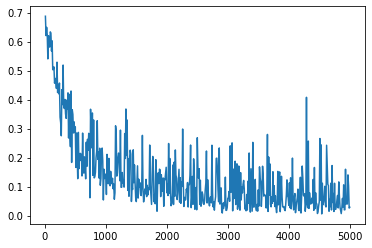

In [30]:
plt.plot(counter[:],loss_history)

# 모델 테스트

In [30]:
siamese_dataset = SiameseNetworkDataset_test(imageFolderDataset=x_test, label = label_test,train_batch_size = Config.test_batch_size )

In [31]:
test_dataloader = DataLoader(siamese_dataset, Config.test_batch_size, shuffle=False)

In [32]:
def test(model, test_dataloader):
    model.eval()
    test_loss = 0
    correct = 0
    count  = 0
    jenuin = []
    imposter = []
    
    real = []
    predict = []
    
    

    # we aren't using `TripletLoss` as the MNIST dataset is simple, so `BCELoss` can do the trick.
#     criterion = torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')
    criterion = torch.nn.BCELoss(weight=None, size_average=None, reduce=None, reduction='mean')

    with torch.no_grad():
        for i, data in enumerate(test_dataloader, 0):
            img0, img1 , label = data
            img0, img1 , label = img0, img1 , label
            
            outputs = model(img0, img1)
            
#             print(outputs)
#             print(np.shape(output))
            
                
            if outputs > 0.5:
                pred = 1
            else:
                pred = 0


    #             test_loss += criterion(outputs, targets).sum().item()  # sum up batch loss
    #             pred = torch.where(outputs > 0.5, 1, 0)  # get the index of the max log-probability
    #             correct += pred.eq(targets.view_as(pred)).sum().item()


            if pred == label:
                correct += 1
            
            
            
            if label == 1:
                jenuin.append(float(outputs))
            else:
                imposter.append(float(outputs))
            
            real.append(float(label))
            predict.append(float(outputs))
            
            
#             print(label, pred)
#             print(pred == label)
#             print("\n")
            
    test_loss /= len(test_dataloader.dataset) 

    # for the 1st epoch, the average loss is 0.0001 and the accuracy 97-98%
    # using default settings. After completing the 10th epoch, the average
    # loss is 0.0000 and the accuracy 99.5-100% using default settings.
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))
    
    return jenuin , imposter, real, predict

In [33]:
jenuin , imposter, label, pred = test(net, test_dataloader)


Test set: Average loss: 0.0000, Accuracy: 477239/490000 (97%)



In [34]:
f = open('label__.csv', 'a', newline='')
wr = csv.writer(f)
wr.writerow(label)
f.close()

f = open('distance.csv', 'a', newline='')
wr = csv.writer(f)
wr.writerow(pred)
f.close()

In [35]:
type(pred)

list

In [36]:
label = np.asarray(label, dtype=object)
label = label.astype(int)

In [37]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(label, pred)


### 유사도 추출

In [36]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=x_test, label = label_test,train_batch_size = Config.test_batch_size )

In [37]:
test_dataloader = DataLoader(siamese_dataset, Config.test_batch_size, shuffle=False)

In [38]:
def test(model, test_dataloader):
    model.eval()
    test_loss = 0
    correct = 0
    count  = 0
    jenuin = []
    imposter = []
    
    

    # we aren't using `TripletLoss` as the MNIST dataset is simple, so `BCELoss` can do the trick.
#     criterion = torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')
    criterion = torch.nn.BCELoss(weight=None, size_average=None, reduce=None, reduction='mean')

    with torch.no_grad():
        for i, data in enumerate(test_dataloader, 0):
            img0, img1 , label = data
            img0, img1 , label = img0, img1 , label
            
            outputs = model(img0, img1)
            
#             print(outputs)
#             print(np.shape(output))
            
                
            if outputs > 0.5:
                pred = 1
            else:
                pred = 0


    #             test_loss += criterion(outputs, targets).sum().item()  # sum up batch loss
    #             pred = torch.where(outputs > 0.5, 1, 0)  # get the index of the max log-probability
    #             correct += pred.eq(targets.view_as(pred)).sum().item()


            if pred == label:
                correct += 1
            
            
            
            if label == 1:
                jenuin.append(float(outputs))
            else:
                imposter.append(float(outputs))
            
            print(label, pred)
            print(pred == label)
            print("\n")
            
    test_loss /= len(test_dataloader.dataset) 

    # for the 1st epoch, the average loss is 0.0001 and the accuracy 97-98%
    # using default settings. After completing the 10th epoch, the average
    # loss is 0.0000 and the accuracy 99.5-100% using default settings.
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))
    
    return jenuin , imposter

In [39]:
jenuin , imposter = test(net, test_dataloader)

tensor([[1.]]) 1
tensor([[True]])


tensor([[0.]]) 0
tensor([[True]])


tensor([[1.]]) 1
tensor([[True]])


tensor([[1.]]) 1
tensor([[True]])


tensor([[0.]]) 0
tensor([[True]])


tensor([[0.]]) 0
tensor([[True]])


tensor([[1.]]) 1
tensor([[True]])


tensor([[1.]]) 1
tensor([[True]])


tensor([[1.]]) 1
tensor([[True]])


tensor([[1.]]) 1
tensor([[True]])


tensor([[0.]]) 0
tensor([[True]])


tensor([[0.]]) 0
tensor([[True]])


tensor([[1.]]) 0
tensor([[False]])


tensor([[0.]]) 0
tensor([[True]])


tensor([[0.]]) 0
tensor([[True]])


tensor([[1.]]) 1
tensor([[True]])


tensor([[1.]]) 1
tensor([[True]])


tensor([[1.]]) 0
tensor([[False]])


tensor([[1.]]) 1
tensor([[True]])


tensor([[0.]]) 0
tensor([[True]])


tensor([[1.]]) 1
tensor([[True]])


tensor([[1.]]) 1
tensor([[True]])


tensor([[0.]]) 0
tensor([[True]])


tensor([[1.]]) 0
tensor([[False]])


tensor([[0.]]) 0
tensor([[True]])


tensor([[1.]]) 1
tensor([[True]])


tensor([[1.]]) 1
tensor([[True]])


tensor([[0.]]) 0
tensor([

tensor([[True]])


tensor([[0.]]) 0
tensor([[True]])


tensor([[0.]]) 0
tensor([[True]])


tensor([[1.]]) 1
tensor([[True]])


tensor([[1.]]) 1
tensor([[True]])


tensor([[1.]]) 1
tensor([[True]])


tensor([[0.]]) 0
tensor([[True]])


tensor([[1.]]) 1
tensor([[True]])


tensor([[1.]]) 1
tensor([[True]])


tensor([[0.]]) 0
tensor([[True]])


tensor([[0.]]) 0
tensor([[True]])


tensor([[0.]]) 0
tensor([[True]])


tensor([[1.]]) 1
tensor([[True]])


tensor([[1.]]) 1
tensor([[True]])


tensor([[0.]]) 0
tensor([[True]])


tensor([[0.]]) 0
tensor([[True]])


tensor([[0.]]) 0
tensor([[True]])


tensor([[0.]]) 0
tensor([[True]])


tensor([[0.]]) 0
tensor([[True]])


tensor([[1.]]) 1
tensor([[True]])


tensor([[1.]]) 1
tensor([[True]])


tensor([[1.]]) 1
tensor([[True]])


tensor([[0.]]) 0
tensor([[True]])


tensor([[1.]]) 0
tensor([[False]])


tensor([[0.]]) 0
tensor([[True]])


tensor([[1.]]) 1
tensor([[True]])


tensor([[0.]]) 0
tensor([[True]])


tensor([[0.]]) 0
tensor([[True]])


tensor([

tensor([[True]])


tensor([[0.]]) 0
tensor([[True]])


tensor([[1.]]) 1
tensor([[True]])


tensor([[0.]]) 0
tensor([[True]])


tensor([[1.]]) 1
tensor([[True]])


tensor([[0.]]) 0
tensor([[True]])


tensor([[1.]]) 1
tensor([[True]])


tensor([[0.]]) 0
tensor([[True]])


tensor([[0.]]) 0
tensor([[True]])


tensor([[0.]]) 0
tensor([[True]])


tensor([[1.]]) 1
tensor([[True]])


tensor([[1.]]) 1
tensor([[True]])


tensor([[0.]]) 0
tensor([[True]])


tensor([[1.]]) 1
tensor([[True]])


tensor([[1.]]) 1
tensor([[True]])


tensor([[0.]]) 0
tensor([[True]])


tensor([[1.]]) 1
tensor([[True]])


tensor([[0.]]) 0
tensor([[True]])


tensor([[0.]]) 0
tensor([[True]])


tensor([[1.]]) 1
tensor([[True]])


tensor([[1.]]) 1
tensor([[True]])


tensor([[0.]]) 0
tensor([[True]])


tensor([[0.]]) 0
tensor([[True]])


tensor([[1.]]) 1
tensor([[True]])


tensor([[0.]]) 0
tensor([[True]])


tensor([[0.]]) 0
tensor([[True]])


tensor([[1.]]) 1
tensor([[True]])


tensor([[1.]]) 1
tensor([[True]])


tensor([[

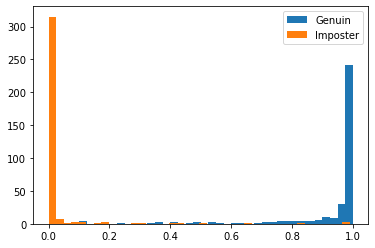

In [40]:
plt.hist(jenuin, bins = 40, label='Genuin')
plt.hist(imposter, bins = 40, label='Imposter')
plt.legend()
plt.show()

In [53]:
# f = open('imposter.csv', 'a', newline='')
# wr = csv.writer(f)
# wr.writerow(imposter)
# f.close()

# f = open('genuin.csv', 'a', newline='')
# wr = csv.writer(f)
# wr.writerow(jenuin)
# f.close()

# 모델 저장

In [49]:
# PATH = './peak_5/'

# torch.save(net, PATH + 'model.pt')  # 전체 모델 저장
# torch.save(net.state_dict(), PATH + 'peak_5.pt')  # 모델 객체의 state_dict 저장
# torch.save({
#     'model': net.state_dict(),
#     'optimizer': optimizer.state_dict()
# }, PATH + 'all.tar')  # 여러 가지 값 저장, 학습 중 진행 상황 저장을 위해 epoch, loss 값 등 일반 scalar값 저장 가능